In [32]:
from glob import glob
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import seaborn as sns
from general_funcions import *

#General plot settings

gen_types = {
    'hydro': 'Hydro',
    'wind': 'Wind',
    'solar': 'Solar',
    'gasCC': 'Gas CC',
    'gasccs': 'Gas CCS',
    'coalccs': 'Coal CCS',
    'SMR': 'SMR',
    'nuclear': 'Nuclear',
    'gasSC': 'Gas SC',
    'coal' : 'Coal',
    'diesel': 'Diesel',
    'biomass': 'Biomass',
    'PHS': 'PHS',
    'LB': 'LB',
    'Biomass': 'Biomass',
    'demand': 'Demand',
    'storage': 'Storage',
    'flow': 'Flow'
}

colors = {
    'hydro': '#a1c5ff',
    'Hydro': '#a1c5ff',
    'wind': '#a9d6ae',
    'Wind': '#a9d6ae',
    'solar': '#fcfba9',
    'Solar': '#fcfba9',
    'gasCC': '#a3a3a3',
    'Gas CC': '#a3a3a3',
    'gasccs': '#a3a3a3',
    'Gas CCS': '#a3a3a3',
    'coalccs': '#a3a3a3',
    'Coal CCS': '#a3a3a3',
    'SMR': '#a36594',
    'Nuclear': '#664264',
    'nuclear': '#664264', 
    'gasSC': '#454545',
    'coal' : '#0d0d0d',
    'diesel': '#707070',
    'biomass': '#a8b3a2',
    'PHS': '#c4fcff',
    'LB': '#b8c3fc',
    'Biomass': '#a8b3a2',

}

os.chdir(fixpath(r"C:\Users\smoha\OneDrive - University of Victoria\Project\tasks\validation\COPPER"))

In [210]:
# listing all scenaiors
scens = pd.DataFrame(glob('*/'))
scens

,0
0,1.4xdem_uwn_constrans/
1,1.5xdem_cwd_constrans/
2,1.5xdem_cwd_unconstrans/
3,1.5xdem_uwd_constrans/
4,1.5xdem_uwd_unconstrans/
5,2.5xdem_cwd_constran/
6,2.5xdem_cwd_unconstran/
7,2.5xdem_uwd_constrans/
8,2.5xdem_uwd_unconstrans/
9,2.8xdem_uwd_constrans/


In [212]:
# Selecting scenario
sel = int(input('Select from table above\n'))
scen = scens.iat[sel,0]
print(scen)

2.5xdem_uwd_constrans/


In [4]:
# reading demand 
demand_base = pd.read_csv('demand.csv', index_col=None, header=None)
demand_base.columns = ['BA', 'demand']
demand_base['demand'] = demand_base['demand'].astype(float)
provinces_full = {
            "British Columbia": "BC",
            "Alberta": "AB",
            "Manitoba": "MN",
            "New Brunswick": "NB",
            "Newfoundland and Labrador": "NL",
            "Nova Scotia": "NS",
            "Ontario": "ON",
            "Quebec": "QB",
            "Saskatchewan": "SK",
            "Prince Edward Island": "PE"
            }

demand_file=pd.DataFrame()
for i, row in demand_base.iterrows():
    demand_file.loc[f'{row["BA"].split(".")[-1]}',f'{provinces_full[row["BA"].split(".")[0]]}.a'] = row['demand']

In [65]:
# multiplying the demnand\
demand_2050 = demand_file*2.5 #change to the desired growth rate
demand_2050.index = demand_2050.index.astype(int)

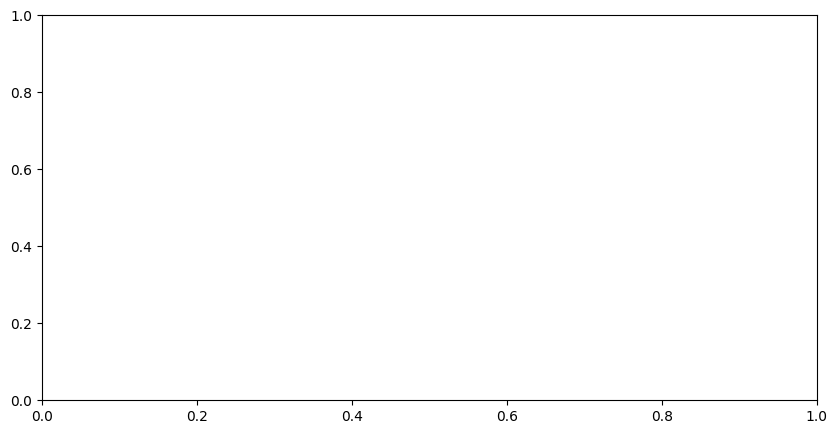

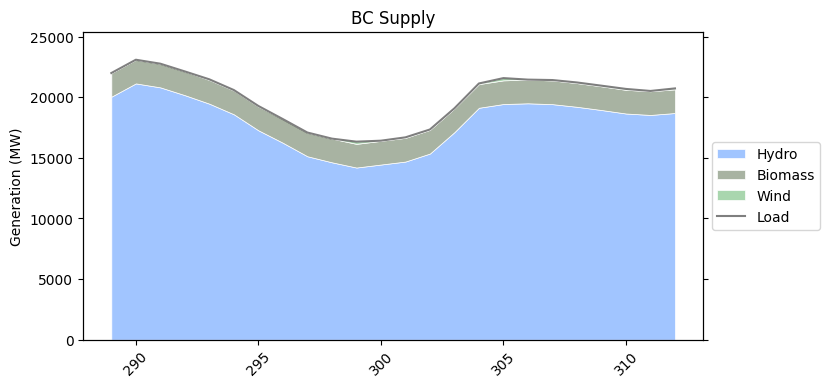

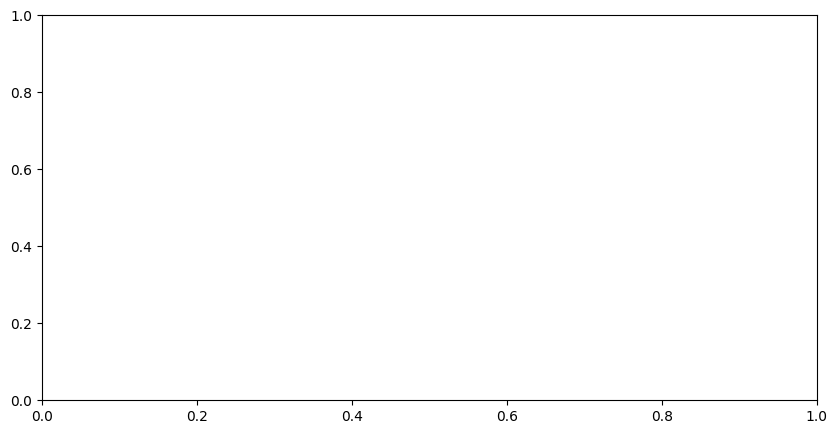

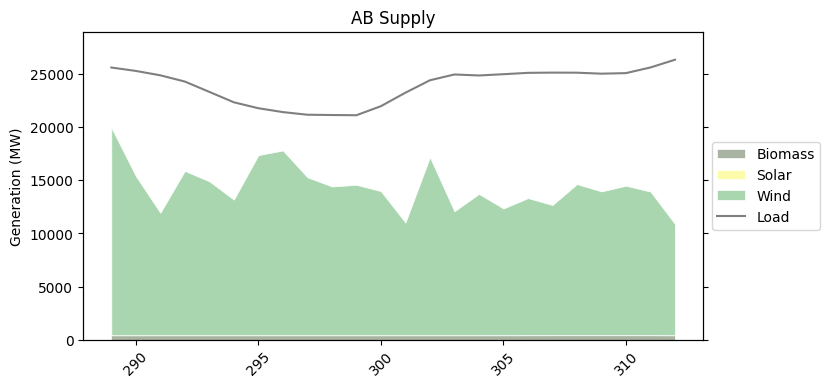

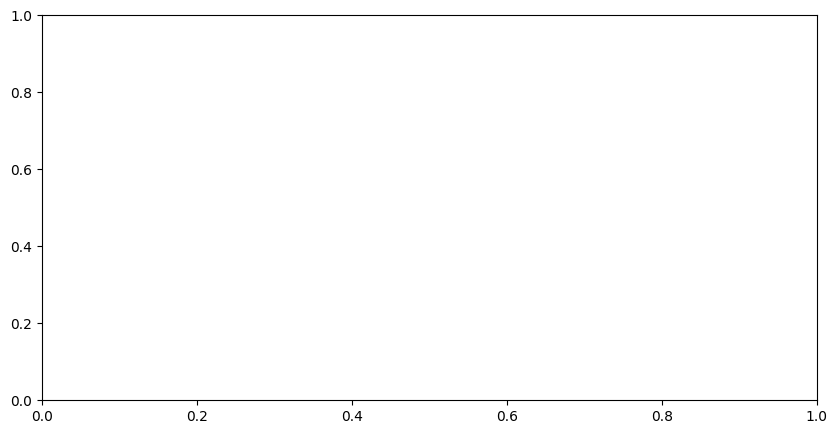

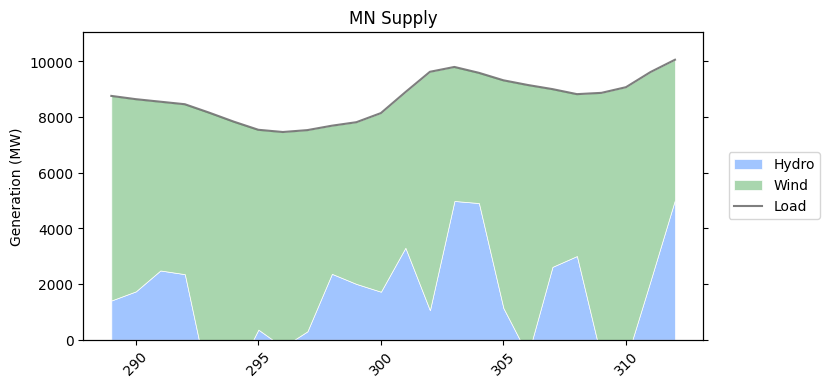

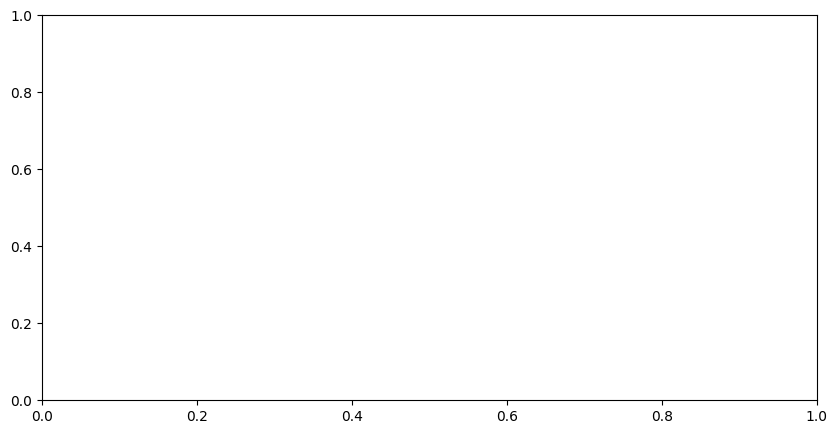

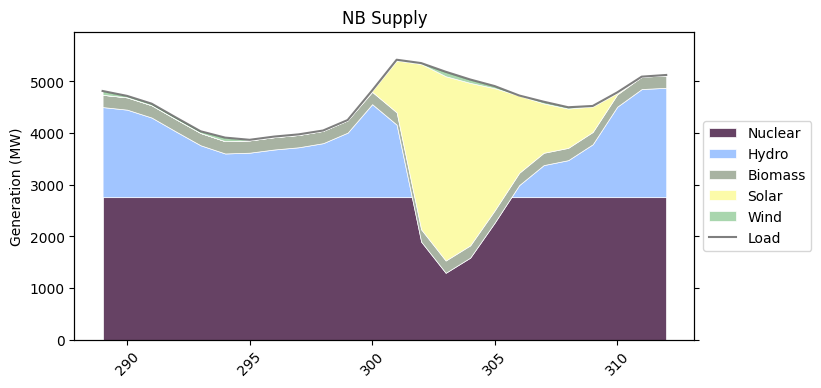

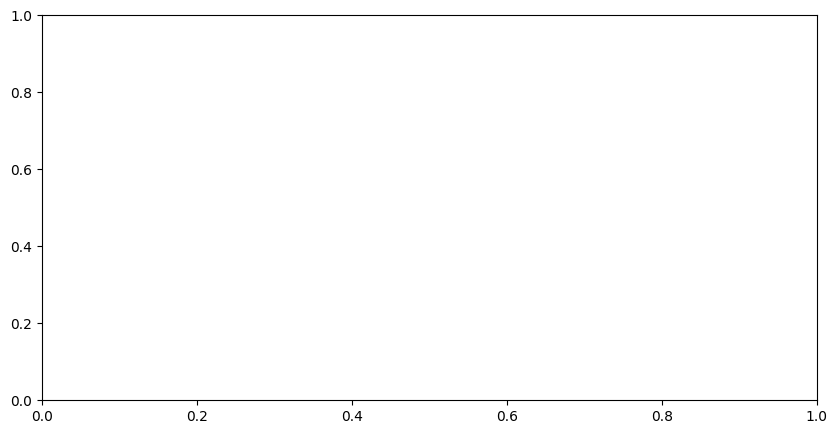

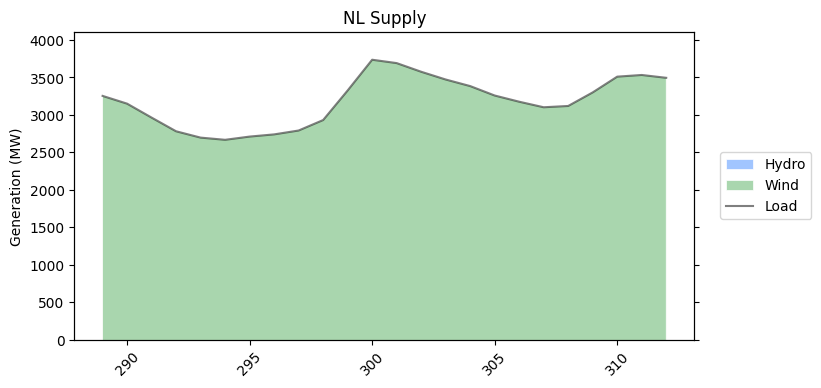

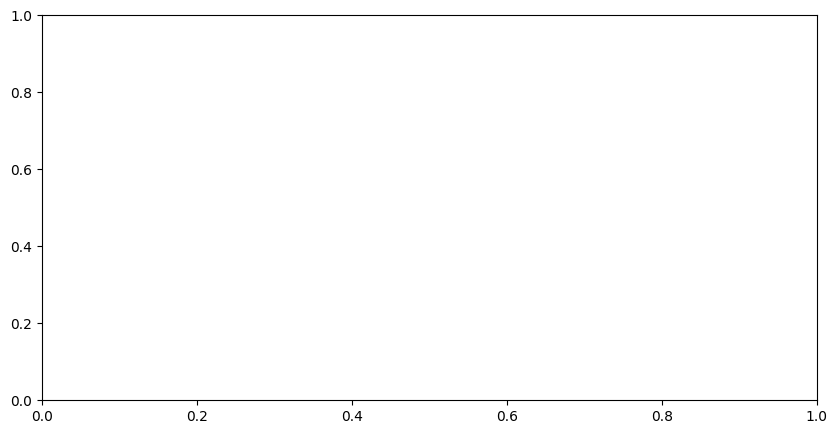

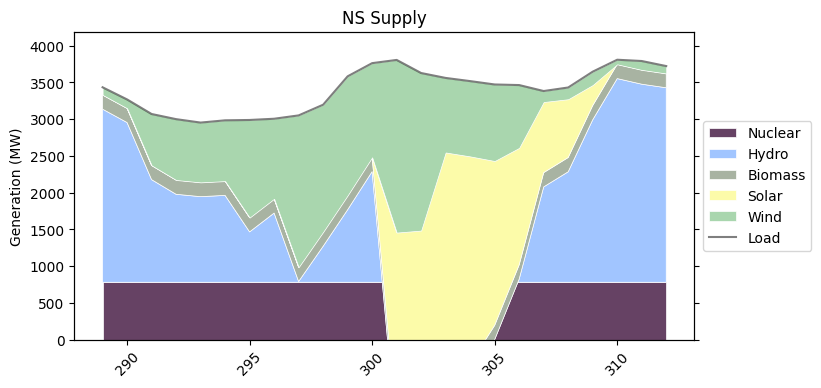

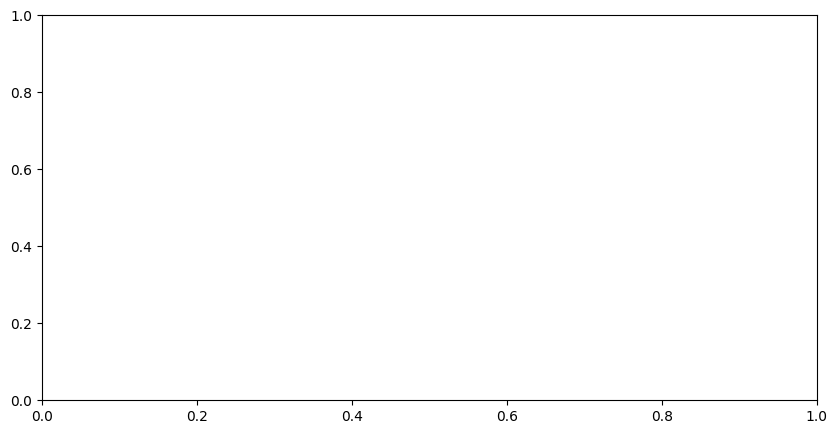

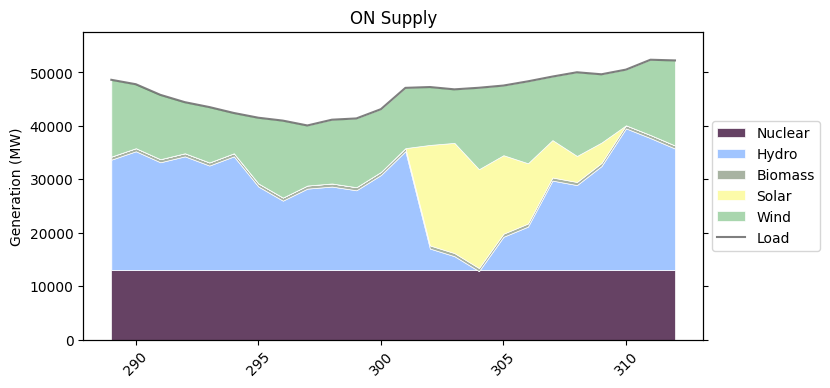

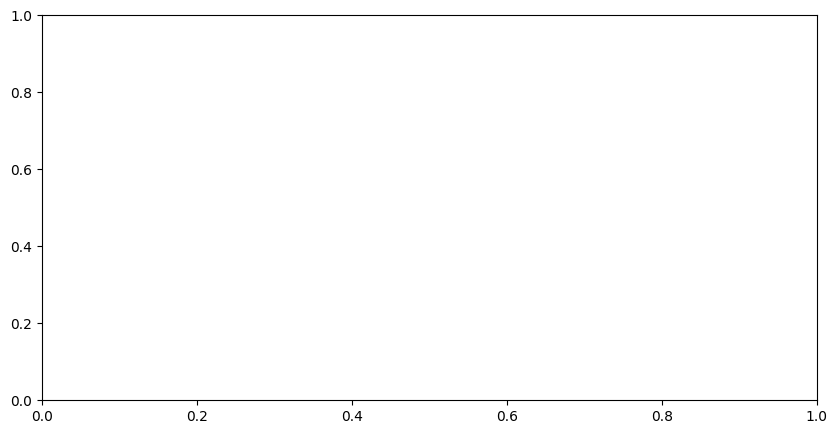

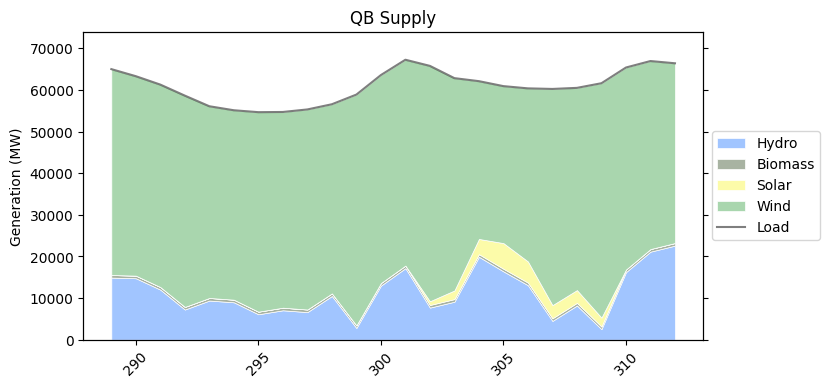

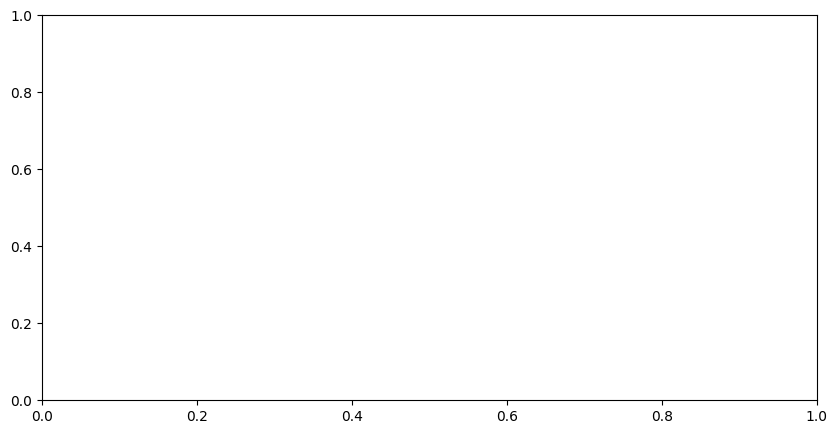

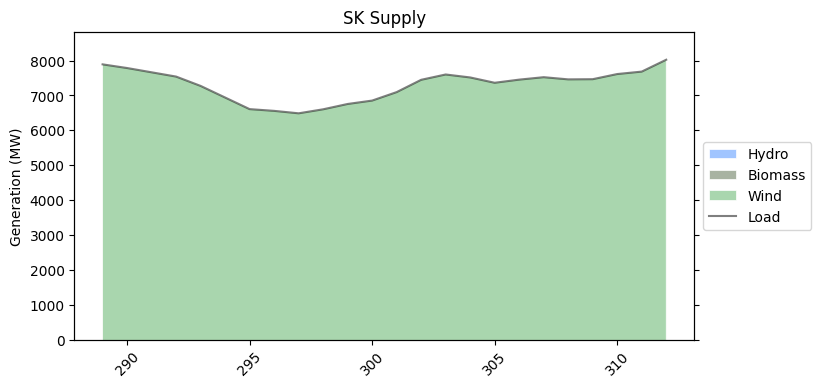

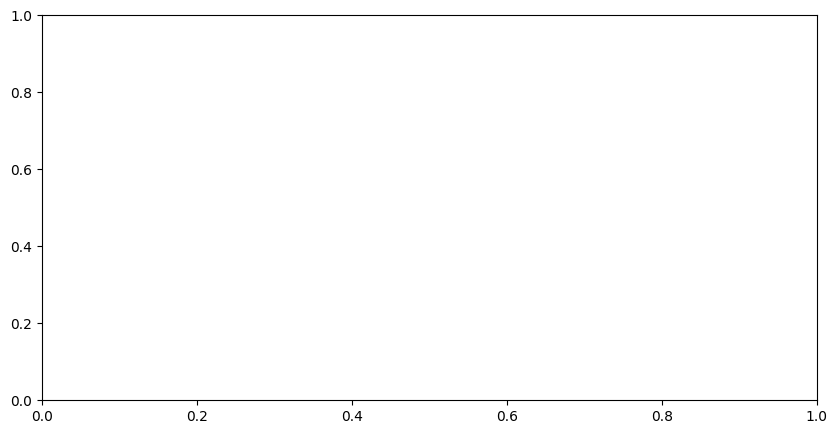

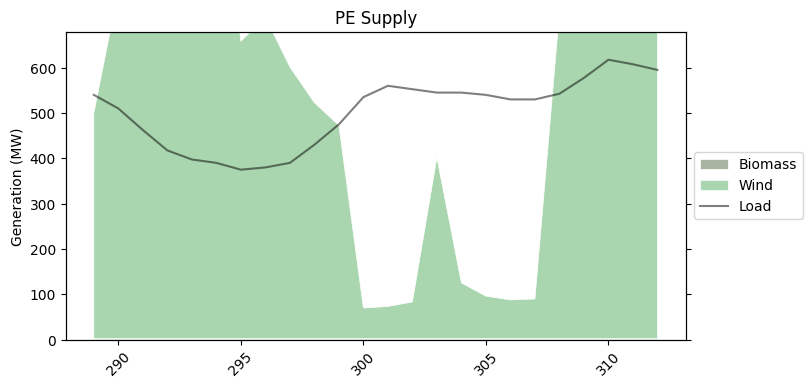

In [66]:
# Reading supply data
supply = pd.read_csv(f'{scen}/supply.csv', header=None)
supply = supply.loc[supply.iloc[:,0] == 2050]
supply.drop(columns=[0], inplace=True)
supply.set_index(supply[1], inplace=True)
supply.columns = ['hour', 'BA', 'gen_type', 'gen']
sup_by_gen = pd.pivot_table(supply, index=['hour', 'BA'], columns='gen_type', values='gen', aggfunc='sum').reset_index()
sup_by_gen.set_index('hour', inplace=True)

windout = pd.read_csv(f'{scen}/windout.csv', header=None)
windout = windout.loc[windout.iloc[:,0] == 2050]
windout.drop(columns=[0], inplace=True)
windout.columns = ['hour', 'BA', 'gen']
windout.set_index('hour', inplace=True)
solarout = pd.read_csv(f'{scen}/solarout.csv', header=None)
solarout = solarout.loc[solarout.iloc[:,0] == 2050]
solarout.drop(columns=[0], inplace=True)
solarout.columns = ['hour', 'BA', 'gen']
solarout.set_index('hour', inplace=True)
hydroout = pd.read_csv(f'{scen}/monthstoragehydroout.csv', header=None)
hydroout = hydroout.loc[hydroout.iloc[:,0] == 2050]
hydroout.drop(columns=[0], inplace=True)
hydroout.columns = ['hour', 'BA', 'gen']
hydroout.set_index('hour', inplace=True)
rorout = pd.read_csv(f'{scen}/daystoragehydroout.csv', header=None)
rorout = rorout.loc[rorout.iloc[:,0] == 2050]
rorout.drop(columns=[0], inplace=True)
rorout.columns = ['hour', 'BA', 'gen']
rorout.set_index('hour', inplace=True)
hydroout = hydroout + rorout
transmission = pd.read_csv(f'{scen}/transmission.csv', header=None)
transmission = transmission.loc[transmission.iloc[:,0] == 2050]
transmission.drop(columns=[0], inplace=True)
transmission.columns = ['hour', 'from', 'to', 'flow']
transmission.set_index('hour', inplace=True)
transmission_to = transmission.groupby(by=['hour', 'to']).sum('flow')
transmission_from = transmission.groupby(by=['hour', 'from']).sum('flow')
transmission_flow = transmission_to['flow'] - transmission_from['flow']
transmission_flow = transmission_flow.reset_index()
transmission_flow.columns = ['hour', 'BA', 'flow']
transmission_flow.set_index('hour', inplace=True)
storagein = pd.read_csv(f'{scen}/storagein.csv', header=None)
storagein = storagein.loc[storagein.iloc[:,0] == 2050]
storagein.drop(columns=[0], inplace=True)
storagein.columns = ['storage_type', 'hour', 'BA', 'in']
storagein = storagein.groupby(by=['hour', 'BA']).sum('in')
storageout = pd.read_csv(f'{scen}/storageout.csv', header=None)
storageout = storageout.loc[storageout.iloc[:,0] == 2050]
storageout.drop(columns=[0], inplace=True)
storageout.columns = ['storage_type', 'hour', 'BA', 'out']
storageout = storageout.groupby(by=['hour', 'BA']).sum('out')
storage_net = storageout['out'] - storagein['in']
storage_net = storage_net.reset_index()
storage_net.set_index('hour', inplace=True)
storage_net.columns = ['BA', 'store_net']
                        

supply_dict = {}
for key, value in provinces_full.items():
    sup_BA = sup_by_gen.loc[sup_by_gen['BA'].str.contains(key)].groupby(by='hour').sum('gen')
    windout_BA = windout.loc[windout['BA'].str.contains(key), 'gen'].groupby(by='hour').sum('gen')
    solarout_BA = solarout.loc[solarout['BA'].str.contains(key), 'gen'].groupby(by='hour').sum('gen')
    hydroout_BA = hydroout.loc[hydroout['BA'].str.contains(key), 'gen'].groupby(by='hour').sum('gen')
    transmission_flow_BA = transmission_flow.loc[transmission_flow['BA'].str.contains(key), 'flow'].groupby(by='hour').sum('flow')
    storage_BA = storage_net.loc[storage_net['BA'].str.contains(key), 'store_net'].groupby(by='hour').sum('store_net')
    if f'{value}.b' in demand_2050.columns:
        demand_BA = demand_2050.loc[:,f'{value}.a'] + demand_2050.loc[:,f'{value}.b']
    else:
        demand_BA = demand_2050.loc[:,f'{value}.a']
    sup_BA = sup_BA.merge(windout_BA, on='hour').merge(solarout_BA, on='hour')\
        .merge(hydroout_BA, on='hour').merge(transmission_flow_BA, on='hour')\
            .merge(storage_BA, on='hour')\
                .merge(demand_BA, left_on='hour', right_on=demand_BA.index, how='left')
    
    sup_BA.rename(columns={'gen_x': 'wind', 'gen_y': 'solar', 'gen': 'hydro',
                            'store_net': 'storage', f'{value}.a': 'demand'}, inplace=True)
    sup_BA.rename(columns=gen_types, inplace=True)
    sup_BA.set_index('hour', inplace=True)

    sup_BA_plt = sup_BA.drop(['Flow', 'Storage', 'Demand'], axis=1).loc[289:312]
    sup_BA_plt = sup_BA_plt.reindex(columns=['SMR', 'Nuclear', 'Hydro',
                                             'Biomass', 'Solar', 'Wind' ])
    sup_BA_plt = sup_BA_plt.loc[:, (sup_BA_plt != 0).any(axis=0)]
    load_curve = sup_BA['Demand'].loc[289:312]

    fig, ax = plt.subplots(figsize=(8,4))
    lns1 = ax.stackplot(sup_BA_plt.index, sup_BA_plt.values.T,
                        labels = sup_BA_plt.columns,
                        colors=[colors[keyc] for keyc in list(sup_BA_plt.columns)],
                        baseline='zero', lw=0.5, edgecolor='white')
    ax.set(ylabel='Generation (MW)')
    ax.tick_params(axis='x', rotation=45)
    ax2 = ax.twinx()
    lns2 = ax2.plot(load_curve, color='black', label='Load', alpha=0.5)
    ax2.set(yticklabels=[])
    ax2.set(ylim=(0, load_curve.max()*1.1))
    ax.set(ylim=(0, ax2.get_ylim()[1]))
    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='center right', ncol=1, bbox_to_anchor=(1.2, 0.5))
    plt.title(f'{value} Supply')

    plt.savefig(f'{scen}/supply_{value}.png', dpi=300, bbox_inches='tight')
    plt.show()

    
    supply_dict[key] = sup_BA
    supply_dict[key].to_csv(f'{scen}/supply_{value}.csv')


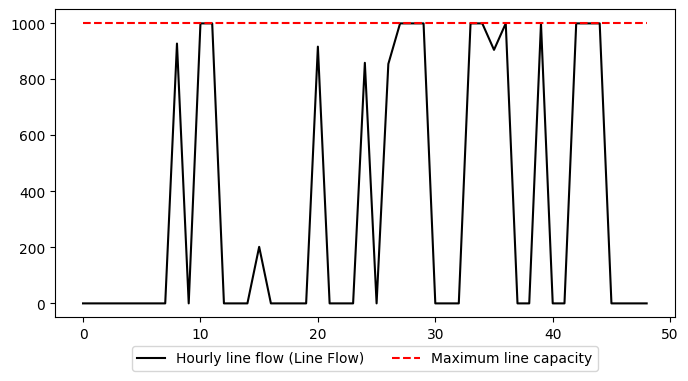

In [98]:
# transmission compliance
transmission = pd.read_csv(f'{scen}/transmission.csv', header=None)
transmission = transmission.loc[transmission.iloc[:,0] == 2050]
transmission.drop(columns=[0], inplace=True)
transmission.columns = ['hour', 'from', 'to', 'flow']
transmission.set_index('hour', inplace=True)
transmission_check = transmission.loc[transmission['from'].str.contains('Alberta.a') 
                                      & transmission['to'].str.contains('British Columbia')].reset_index()

fig, ax = plt.subplots(figsize=(8,4))
lns1 = ax.plot(transmission_check['flow'].loc[0:48], color='black', label='Line Flow')
handles, labels = ax.get_legend_handles_labels()
lns2 = ax.hlines(y=1000,xmin=0, xmax=48, color='r', linestyle='--',  label='Maximum line capacity')
ax.legend(handles=[Line2D([], [], color="black", label=f"Hourly line flow ({labels[0]})")
                      , Line2D([0], [0], color="r", label=lns2.get_label(), linestyle='--')]
                      , loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=2)
plt.savefig(f'{scen}/transmission.png', dpi=300, bbox_inches='tight')

Minimum hydro generation in BC is 10.00% of maximum capacity


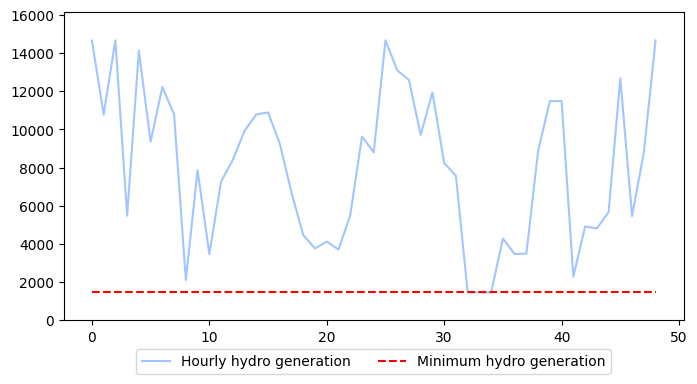

In [144]:
# hydro min gen compliance
hydroout = pd.read_csv(f'{scen}/monthstoragehydroout.csv', header=None)
hydroout = hydroout.loc[hydroout.iloc[:,0] == 2050]
hydroout.drop(columns=[0], inplace=True)
hydroout.columns = ['hour', 'BA', 'gen']
hydroout.set_index('hour', inplace=True)
rorout = pd.read_csv(f'{scen}/daystoragehydroout.csv', header=None)
rorout = rorout.loc[rorout.iloc[:,0] == 2050]
rorout.drop(columns=[0], inplace=True)
rorout.columns = ['hour', 'BA', 'gen']
rorout.set_index('hour', inplace=True)
hydroout = hydroout + rorout
hydroout_val = hydroout.loc[hydroout['BA'].str.contains('British Columbia.a')].reset_index()
fig, ax = plt.subplots(figsize=(8,4))
lns1 = ax.plot(hydroout_val['gen'].loc[0:48], color='#a1c5ff', label='Line Flow')
handles, labels = ax.get_legend_handles_labels()
lns2 = ax.hlines(y=hydroout_val['gen'].max()*0.1,xmin=0, xmax=48, color='r', linestyle='--',  label='Minimum hydro generation')
ax.set(ylim=(0, hydroout_val['gen'].max()*1.1))
ax.legend(handles=[Line2D([], [], color="#a1c5ff", label=f"Hourly hydro generation")
                      , Line2D([0], [0], color="r", label=lns2.get_label(), linestyle='--')]
                      , loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=2)
plt.savefig(f'{scen}/hydro_val.png', dpi=300, bbox_inches='tight')
print(f'Minimum hydro generation in BC is {hydroout_val["gen"].min()/hydroout_val["gen"].max()*100:.2f}% of maximum capacity')

2.5xdem_uwd_constrans/


/tmp/ipykernel_916/2795522068.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  wind_cap = wind_cap.groupby('location').sum().reset_index()
/tmp/ipykernel_916/2795522068.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  wind_recon = wind_recon.groupby('location').sum().reset_index()


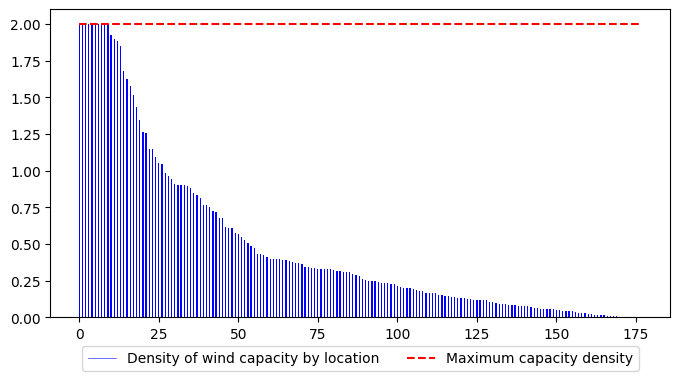

In [213]:
# wind capacity land use constraint

print(scen)
if 'cwd' in scen:
    landuse = 0.5
elif 'uwd' in scen:
    landuse = 2 

wind_extant = pd.read_csv('extant_wind_solar.csv')
wind_extant[['location', 'type']] = wind_extant['location'].str.split('.', expand=True)
wind_extant['location'] = wind_extant['location'].astype(int)
wind_extant = wind_extant.loc[wind_extant['type'] == 'wind', ['location','2050']]
wind_extant.set_index('location', inplace=True)
wind_extant.sort_index(inplace=True)
wind_extant.columns = ['extant']
wind_cap = pd.read_csv(f'{scen}/capacity_wind.csv', header=None)
wind_cap['location'] = wind_cap[1].apply(lambda x: pd.Series(int(x.split("'")[1])))
wind_cap = wind_cap.groupby('location').sum().reset_index()
wind_cap.set_index('location', inplace=True)
wind_recon = pd.read_csv(f'{scen}/capacity_wind_recon.csv', header=None)
wind_recon['location'] = wind_recon[1].apply(lambda x: pd.Series(int(x.split("'")[1])))
wind_recon = wind_recon.groupby('location').sum().reset_index()
wind_recon.set_index('location', inplace=True)
wind_cap = wind_cap + wind_recon
wind_cap = wind_cap.merge(wind_extant, on='location', how='left').fillna(0)
wind_cap['total'] = wind_cap[2] + wind_cap['extant']
surface_area = pd.read_csv('surface_area.csv', header=None)
surface_area.columns = ['location', 'area']
wind_cap = wind_cap.merge(surface_area, left_on='location', right_on='location', how='left')
wind_cap['capacity_density'] = wind_cap['total'] / wind_cap['area']

fig, ax = plt.subplots(figsize=(8,4))
y = wind_cap.loc[wind_cap['capacity_density'] != 0,'capacity_density'].sort_values(ascending=False).reset_index(drop=True)
lns1 = ax.bar(y.index, y, color='b', label='Capacity density (MW/km2)', width=0.4)
handles, labels = ax.get_legend_handles_labels()
lns2 = ax.hlines(y=landuse,xmin=0, xmax=len(y), color='r', linestyle='--'
                 , label='Maximum capacity density')
ax.legend(handles=[Line2D([], [], color="b", label=f"Density of wind capacity by location", linewidth=0.4)
                      , Line2D([0], [0], color="r", label=lns2.get_label(), linestyle='--')]
                      , loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=2)
plt.savefig(f'{scen}/capacity_density.png', dpi=300, bbox_inches='tight')

What continues is run on remote CC database to access data for the sensitivity analysis section

In [ ]:
from glob import glob
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import re
import seaborn as sns

#General plot settings

gen_types = {
    'hydro': 'Hydro',
    'wind': 'Wind',
    'solar': 'Solar',
    'gasCC': 'Gas CC',
    'gasccs': 'Gas CCS',
    'coalccs': 'Coal CCS',
    'SMR': 'SMR',
    'nuclear': 'Nuclear',
    'gasSC': 'Gas SC',
    'coal' : 'Coal',
    'diesel': 'Diesel',
    'biomass': 'Biomass',
    'PHS': 'PHS',
    'LB': 'LB',
    'Biomass': 'Biomass',
    'demand': 'Demand',
    'storage': 'Storage',
    'flow': 'Flow'
}

colors = {
    'hydro': '#a1c5ff',
    'Hydro': '#a1c5ff',
    'wind': '#a9d6ae',
    'Wind': '#a9d6ae',
    'solar': '#fcfba9',
    'Solar': '#fcfba9',
    'gasCC': '#a3a3a3',
    'Gas CC': '#a3a3a3',
    'gasccs': '#a3a3a3',
    'Gas CCS': '#a3a3a3',
    'coalccs': '#a3a3a3',
    'Coal CCS': '#a3a3a3',
    'SMR': '#a36594',
    'Nuclear': '#664264',
    'nuclear': '#664264', 
    'gasSC': '#454545',
    'coal' : '#0d0d0d',
    'diesel': '#707070',
    'biomass': '#a8b3a2',
    'PHS': '#c4fcff',
    'LB': '#b8c3fc',
    'Biomass': '#a8b3a2',
}

os.chdir('/home/smmiri/projects/rrg-mcpher16/ml_shared/COPPER7_3_samplegen/')

In [ ]:
# SA for carbon taxation - reading inputs
ctax_dict = {}
for i in range(0,1999):
    input_file = f'inputs/COPPER7.3_{i}.py'
    with open(input_file, 'r') as f:
                file_contents = f.read()
            # extract the dictionary from the file contents using regular expressions
    match = re.search(r'ctax\s*=\s*{(.+?)}', file_contents, re.DOTALL)
    if match:
        dict_string = "{" + match.group(1) + "}"
        ctax = eval(dict_string)
        ctax_dict[i]=  round(((ctax['2050']-95)/5.5)/5, 3)

In [ ]:
# SA for carbon taxation - reading emissions
emission_dict = {}
output_dirs = os.listdir('outputs')

for i, dir in enumerate(output_dirs):
    scen = output_dirs[i].split('_')[0]
    output_file = f'outputs/{dir}/Results_summary.xlsx'
    emissions = pd.read_excel(output_file, sheet_name='carbon_national', index_col=0)
    emission_dict[scen] = emissions.loc[2050, 'MT CO2']

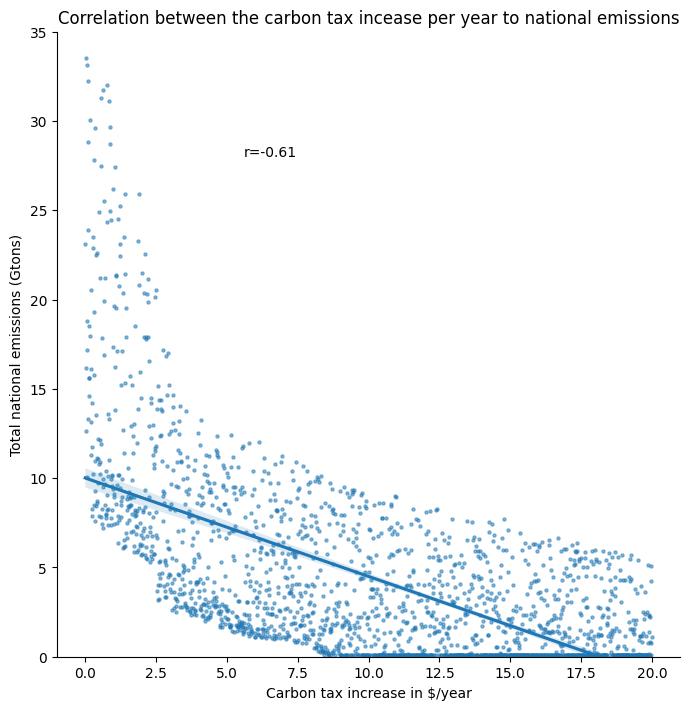

In [ ]:
# correlation graph
from pathlib import Path
from scipy import stats

scratch = '/home/smmiri/scratch/COPPER_validation'
df_emission = pd.DataFrame.from_dict(emission_dict, orient='index')
df_emission.set_index(df_emission.index.astype(int), inplace=True)
df_ctax = pd.DataFrame.from_dict(ctax_dict, orient='index')
corr = df_ctax.merge(df_emission, left_index=True, right_index=True)
corr.columns = ['ctax', 'emissions']
corr.sort_index(inplace=True)
corr.to_csv(f'{scratch}/corr.csv')
r, p = stats.pearsonr(corr['ctax'], corr['emissions'])
lm = sns.lmplot(x='ctax', y='emissions', data=corr, height=7, aspect=1, scatter_kws={'alpha': 0.5, "s": 5})
ax = lm.axes[0,0]
plt.title('Correlation between the carbon tax incease per year to national emissions')
plt.xlabel('Carbon tax increase in $/year')
plt.text(0.3, 0.8, 'r={:.2f}'.format(r), transform=ax.transAxes)
plt.ylabel('Total national emissions (Gtons)')
plt.ylim(0, 35)
plt.savefig(Path(scratch, 'ctax_emi_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# SA for carbon taxation - reading VRE capacities
wind_dict = {}
solar_dict = {}
emitting_dict = {}

for i, dir in enumerate(output_dirs):
    scen = int(output_dirs[i].split('_')[0])
    output_file = f'outputs/{dir}/Results_summary.xlsx'
    canada_cap = pd.read_excel(output_file, sheet_name='Canada_generation_mix', index_col=0)
    solar_dict[scen] = canada_cap.loc['solar', '2050']
    wind_dict[scen] = canada_cap.loc['wind', '2050']
    emitting_dict[scen] = canada_cap.loc[['coal', 'diesel', 'gasCC', 'gasSC'], '2050'].sum()

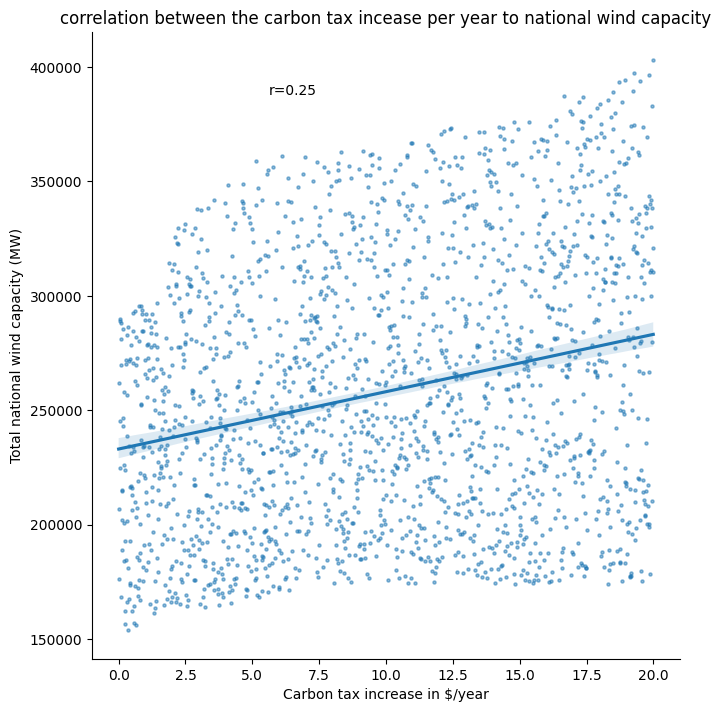

In [ ]:
df_wind = pd.DataFrame.from_dict(wind_dict, orient='index')
df_solar = pd.DataFrame.from_dict(solar_dict, orient='index')
corr_VRE = df_ctax.merge(df_wind, left_index=True, right_index=True)
corr_VRE.sort_index(inplace=True)
corr_VRE = corr_VRE.merge(df_solar, left_index=True, right_index=True)
corr_VRE.columns = ['ctax', 'wind', 'solar']
corr_VRE.to_csv(f'{scratch}/corr_VRE.csv')
r, p = stats.pearsonr(corr_VRE['ctax'], corr_VRE['wind'])
lm = sns.lmplot(x='ctax', y='wind', data=corr_VRE, height=7, aspect=1, scatter_kws={'alpha': 0.5, "s": 5})
ax = lm.axes[0,0]
plt.title('correlation between the carbon tax incease per year to national wind capacity')
plt.xlabel('Carbon tax increase in $/year')
plt.text(0.3, 0.9, 'r={:.2f}'.format(r), transform=ax.transAxes)
plt.ylabel('Total national wind capacity (MW)')
plt.savefig(Path(scratch, 'ctax_wind_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()

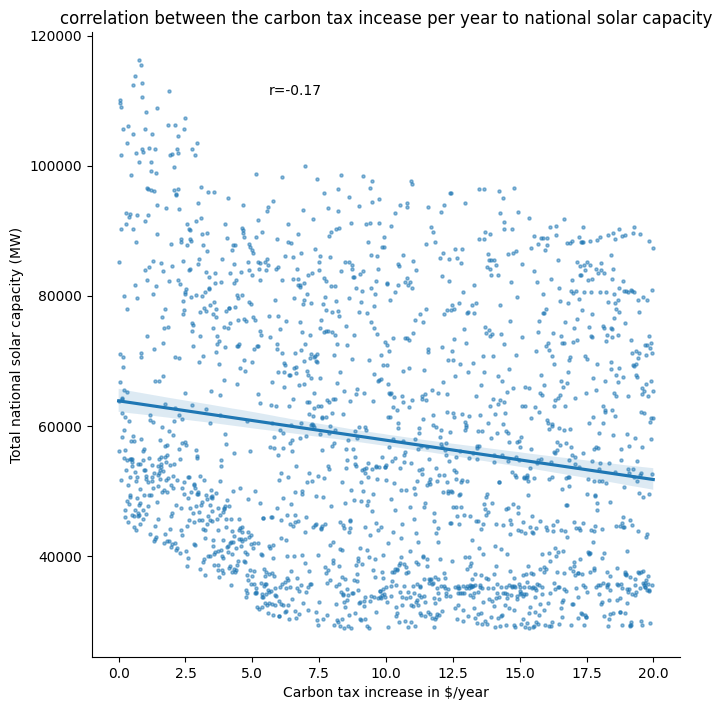

In [ ]:
r, p = stats.pearsonr(corr_VRE['ctax'], corr_VRE['solar'])
lm = sns.lmplot(x='ctax', y='solar', data=corr_VRE, height=7, aspect=1, scatter_kws={'alpha': 0.5, "s": 5})
ax = lm.axes[0,0]
plt.title('correlation between the carbon tax incease per year to national solar capacity')
plt.xlabel('Carbon tax increase in $/year')
plt.text(0.3, 0.9, 'r={:.2f}'.format(r), transform=ax.transAxes)
plt.ylabel('Total national solar capacity (MW)')
plt.savefig(Path(scratch, 'ctax_solar_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()

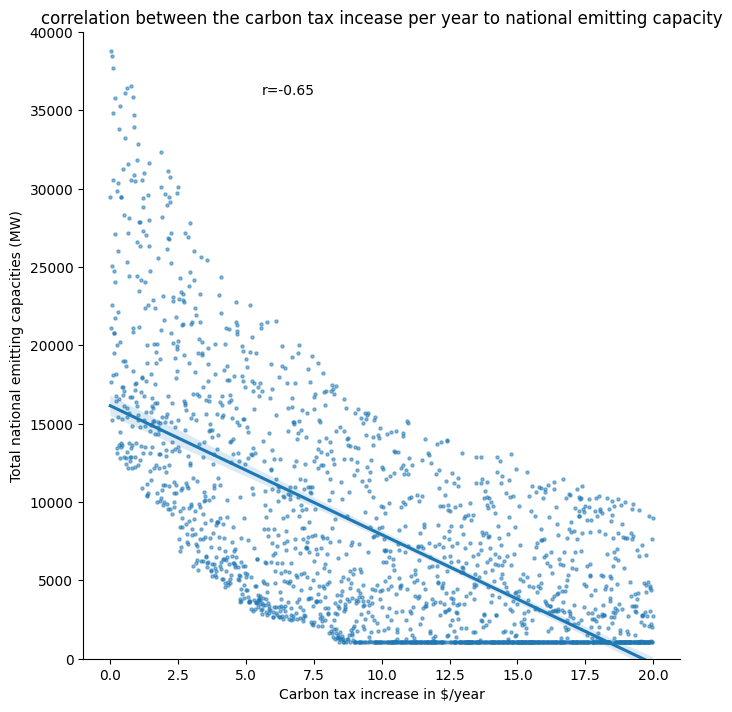

In [ ]:
df_emitting = pd.DataFrame.from_dict(emitting_dict, orient='index')
corr_emitting = df_ctax.merge(df_emitting, left_index=True, right_index=True)
corr_emitting.columns = ['ctax', 'emitting']
corr_emitting.sort_index(inplace=True)
corr_emitting.to_csv(f'{scratch}/corr_emitting.csv')
r, p = stats.pearsonr(corr_emitting['ctax'], corr_emitting['emitting'])
lm = sns.lmplot(x='ctax', y='emitting', data=corr_emitting, height=7, aspect=1, scatter_kws={'alpha': 0.5, "s": 5})
ax = lm.axes[0,0]
plt.title('correlation between the carbon tax incease per year to national emitting capacity')
plt.xlabel('Carbon tax increase in $/year')
plt.text(0.3, 0.9, 'r={:.2f}'.format(r), transform=ax.transAxes)
plt.ylabel('Total national emitting capacities (MW)')
plt.ylim(0,40000)
plt.savefig(Path(scratch, 'ctax_emitting_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# SA for demand growth - readin demand growth
growth = pd.read_csv(f'{scratch}/pop_growth.csv', header=None, index_col=0)
growth.columns = ['growth']

In [ ]:
# SA for demand growth - outputs / capacities
total_cap = {}
for i, dir in enumerate(output_dirs):
    scen = int(output_dirs[i].split('_')[0])
    output_file = f'outputs/{dir}/Results_summary.xlsx'
    canada_cap = pd.read_excel(output_file, sheet_name='Canada_generation_mix', index_col=0)
    total_cap[scen] = canada_cap.loc[:,'2050'].sum()

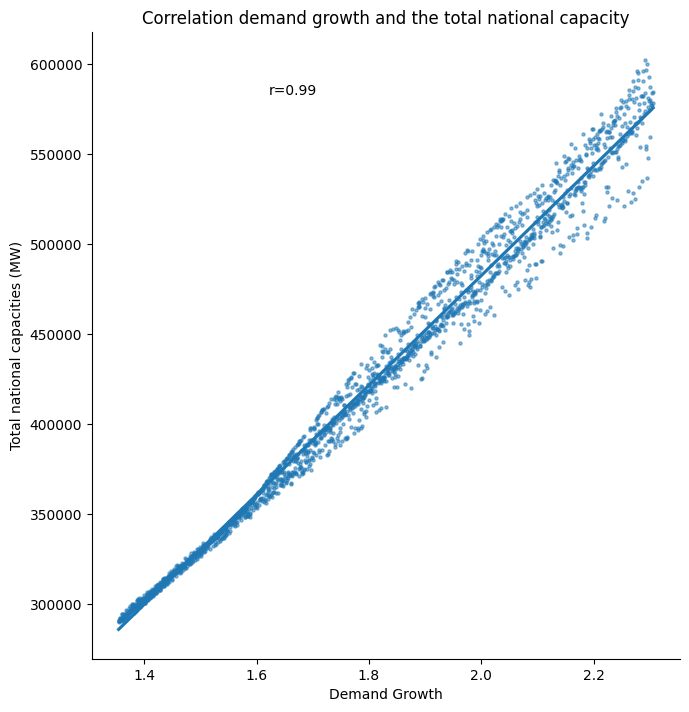

In [ ]:
# SA for growth / capacity
df_cap = pd.DataFrame.from_dict(total_cap, orient='index')
df_cap.columns = ['total_cap']
corr_growth_cap = growth.merge(df_cap, left_index=True, right_index=True)
corr_growth_cap.columns = ['growth', 'total_cap']
corr_growth_cap.sort_index(inplace=True)
corr_growth_cap.to_csv(f'{scratch}/corr_growth_cap.csv')
r, p = stats.pearsonr(corr_growth_cap['growth'], corr_growth_cap['total_cap'])
lm = sns.lmplot(x='growth', y='total_cap', data=corr_growth_cap, height=7, aspect=1, scatter_kws={'alpha': 0.5, "s": 5})
ax = lm.axes[0,0]
plt.title('Correlation demand growth and the total national capacity')
plt.xlabel('Demand Growth')
plt.text(0.3, 0.9, 'r={:.2f}'.format(r), transform=ax.transAxes)
plt.ylabel('Total national capacities (MW)')
plt.savefig(Path(scratch, 'growth_total_cap_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
output_dirs_cp5 = os.listdir('/home/smmiri/projects/rrg-mcpher16/ml_shared/COPPER5_CapCost_CTax_PopGrowth_all_False/outputs')

In [ ]:
# SA for VRE prices - reading VRE capacities
wind_dict = {}
solar_dict = {}

for i, dir in enumerate(output_dirs_cp5):
    scen = int(output_dirs_cp5[i].split('_')[0])
    output_cp5 = '/home/smmiri/projects/rrg-mcpher16/ml_shared/COPPER5_CapCost_CTax_PopGrowth_all_False/outputs'
    output_file = f'{output_cp5}/{dir}/Total_Generation_ABA.xlsx'
    canada_cap = pd.read_excel(output_file, index_col=0)
    solar_dict[scen] = canada_cap.loc['solar', :].sum()
    wind_dict[scen] = canada_cap.loc['wind', :].sum()

In [ ]:
# SA for VRE prices - reading inputs
input_dir = '/home/smmiri/projects/rrg-mcpher16/ml_shared/COPPER5_CapCost_CTax_PopGrowth_all_False/inputs/'
solar_price_dict =  {}
wind_price_dict = {}
for i in range(0,999):
    price_file_dir = f'{input_dir}/Generation_type_data_{i}.xlsx'
    price_file = pd.read_excel(price_file_dir, index_col=0)
    solar_price_dict[i] = price_file.loc['solar', 'capitalcost']
    wind_price_dict[i] = price_file.loc['wind', 'capitalcost']

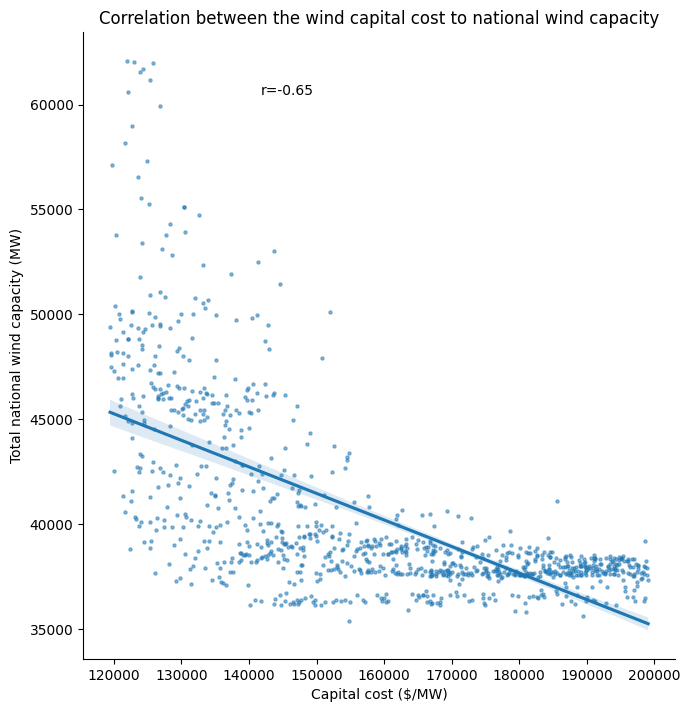

In [ ]:
df_wind_cp5 = pd.DataFrame.from_dict(wind_dict, orient='index')
df_wind_cp5['sum'] = df_wind_cp5.sum(axis=1)
df_wind_cp5 = pd.DataFrame(df_wind_cp5.loc[:,'sum'])
df_solar_cp5 = pd.DataFrame.from_dict(solar_dict, orient='index')
df_solar_cp5['sum'] = df_solar_cp5.sum(axis=1)
df_solar_cp5 = pd.DataFrame(df_solar_cp5.loc[:,'sum'])
df_wind_price = pd.DataFrame.from_dict(wind_price_dict, orient='index')
df_solar_price = pd.DataFrame.from_dict(solar_price_dict, orient='index')

corr_wind_prices = df_wind_cp5.merge(df_wind_price, left_index=True, right_index=True)
corr_wind_prices.columns = ['wind_cap', 'wind_price']
corr_wind_prices.to_csv(f'{scratch}/corr_wind_prices.csv')
r, p = stats.pearsonr(corr_wind_prices['wind_price'], corr_wind_prices['wind_cap'])
lm = sns.lmplot(x='wind_price', y='wind_cap', data=corr_wind_prices, height=7, aspect=1, scatter_kws={'alpha': 0.5, "s": 5})
ax = lm.axes[0,0]
plt.title('Correlation between the wind capital cost to national wind capacity')
plt.xlabel('Capital cost ($/MW)')
plt.text(0.3, 0.9, 'r={:.2f}'.format(r), transform=ax.transAxes)
plt.ylabel('Total national wind capacity (MW)')
plt.savefig(Path(scratch, 'wind_price_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()

/home/smmiri/etl-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


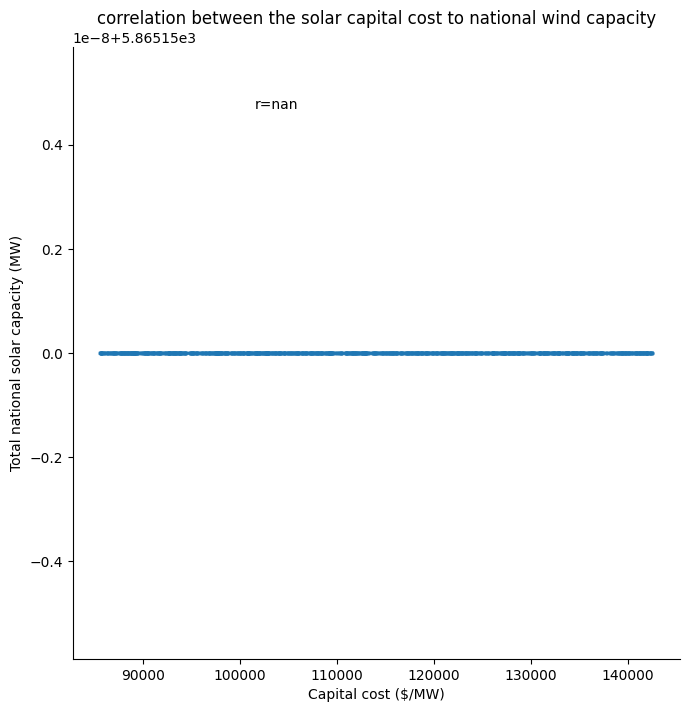

In [ ]:
corr_solar_prices = df_solar_cp5.merge(df_solar_price, left_index=True, right_index=True)
corr_solar_prices.columns = ['solar_cap', 'solar_price']
corr_solar_prices.to_csv(f'{scratch}/corr_solar_prices.csv')
r, p = stats.pearsonr(corr_solar_prices['solar_price'], corr_solar_prices['solar_cap'])
lm = sns.lmplot(x='solar_price', y='solar_cap', data=corr_solar_prices, height=7, aspect=1, scatter_kws={'alpha': 0.5, "s": 5})
ax = lm.axes[0,0]
plt.title('correlation between the solar capital cost to national wind capacity')
plt.xlabel('Capital cost ($/MW)')
plt.text(0.3, 0.9, 'r={:.2f}'.format(r), transform=ax.transAxes)
plt.ylabel('Total national solar capacity (MW)')
plt.savefig(Path(scratch, 'solar_price_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# stroage constraint validity - reading inputs

from pathlib import Path
scratch = '/home/smmiri/scratch/COPPER_validation'
scratch = Path(scratch)
storage_dict = {}
for i in range(0,200):
    input_file = f'{scratch.parent}/COPPER7.3_{i}.py'
    with open(input_file, 'r') as f:
                file_contents = f.readlines()
    match = re.search(r'\d+', file_contents[139])
    #ctax\s*=\s*{(.+?)}
    storage = match.group(0)
    storage = eval(storage)
    storage_dict[i]=  round(storage)
df_storage = pd.DataFrame.from_dict(storage_dict, orient='index')
df_storage.columns = ['storage_limit']

In [ ]:
# stroage constraint validity - reading outputs
output_dirs_storage = os.listdir(scratch.parent / 'outputs')
storage_cap = pd.DataFrame()
for dir in output_dirs_storage:
    scen = int(dir.split('_')[0])
    output_file = scratch.parent / f'outputs/{dir}/Results_summary.xlsx'
    canada_cap = pd.read_excel(output_file, sheet_name='ABA_generation_mix', index_col=0)
    storage_cap.loc[scen, 'BC'] = canada_cap.iloc[[9,10], 27].sum()
    storage_cap.loc[scen, 'AB'] = canada_cap.iloc[[9,10], 28].sum()
    storage_cap.loc[scen, 'ON'] = canada_cap.iloc[[9,10], 31].sum()
    storage_cap.loc[scen, 'NS'] = canada_cap.iloc[[9,10], 38].sum()


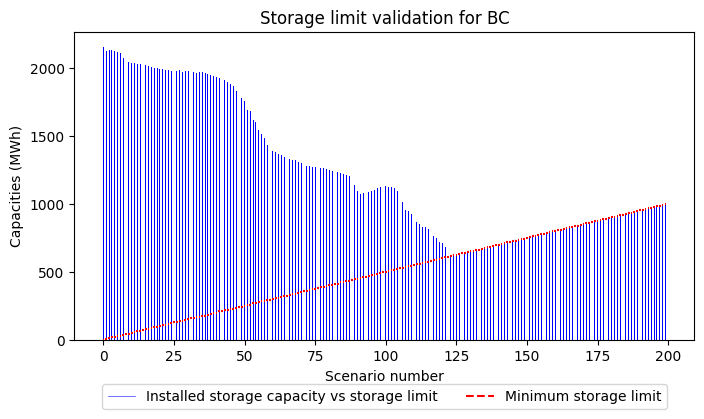

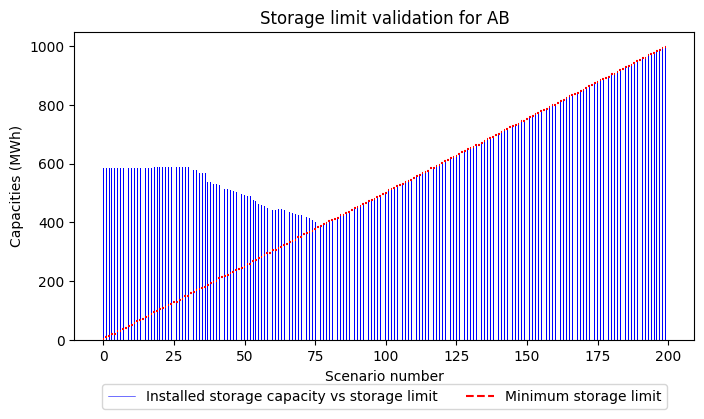

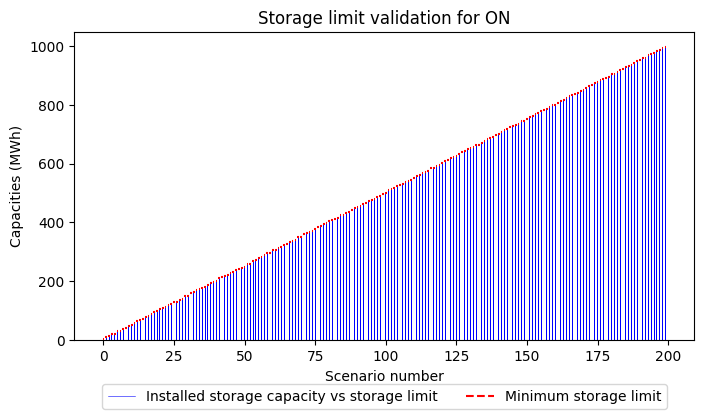

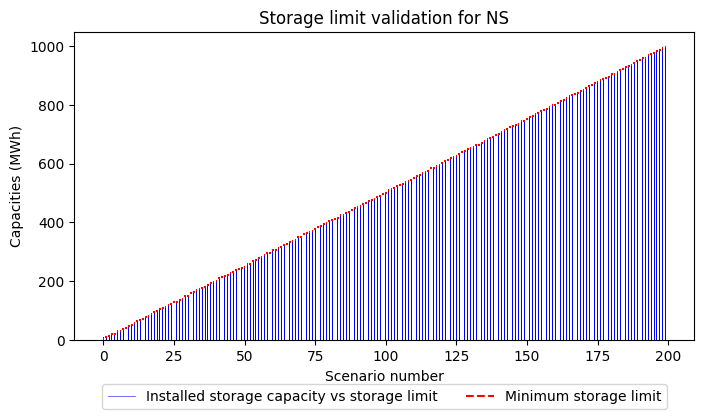

In [ ]:
df_plt = df_storage.merge(storage_cap, left_index=True, right_index=True)
df_plt.sort_values(by='storage_limit', inplace=True)
df_plt.reset_index(inplace=True, drop=True)
df_plt.to_csv(scratch / 'df_plt.csv')
for ap in storage_cap.columns:
    fig, ax = plt.subplots(figsize=(8,4))
    lns1 = ax.bar(df_plt.index, df_plt[ap], color='b', label=f'Storage capacitu of {ap}', width=0.3)
    handles, labels = ax.get_legend_handles_labels()
    for i in df_plt.index:
        lns2 = ax.hlines(y=df_plt.loc[i,'storage_limit'],xmin=i-0.3, xmax=i+0.3, color='r', linestyle='--'
                    , label='Minimum storage limit')
    ax.legend(handles=[Line2D([], [], color="b", label=f"Installed storage capacity vs storage limit", linewidth=0.4)
                        , Line2D([0], [0], color="r", label=lns2.get_label(), linestyle='--')]
                        , loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2)
    plt.ylabel('Capacities (MWh)')
    plt.xlabel('Scenario number')
    plt.title(f'Storage limit validation for {ap}')
    plt.savefig(Path(scratch, f'storage_limite_validation_{ap}.png'), dpi=300, bbox_inches='tight')
    plt.show()